Motivation:
    
Given the information on gpu and kernel, model the concurrent kernel runtime.

**Shortcomings**:
* assume the kernels are in 1D grid
* the input for the model should be a list of all the kernels in N cuda streams. Right now, we assume the two kernels are from two different cuda streams, which seems confusing.

**New**:

* the coming kernel starting time can be adjustable
* warp modeling inside function, use global data trace table to keep track each trace

**Test**:
    * two kernels have overlapping
    * they have different starting time, instead of 0 as the default
    * change the sm num to 6

In [1]:
from math import *
import pandas as pd
import numpy as np
import copy  # deep copy objects

In [2]:
class DeviceInfo():
    def __init__(self, sm_num=0, sharedmem_per_sm=0, reg_per_sm=0, maxthreads_per_sm=0):
        self.sm_num = sm_num
        self.sharedmem_per_sm = sharedmem_per_sm # bytes
        self.reg_per_sm = reg_per_sm
        self.maxthreads_per_sm = maxthreads_per_sm
        
class KernelInfo():
    def __init__(self, blockDim=0, gridDim=0, reg_per_thread=0, sharedmem_per_blk=0, runtime_ms = 0, start = 0):
        self.blockDim = blockDim
        self.gridDim = gridDim
        self.reg_per_thread = reg_per_thread
        self.sharedmem_per_blk =  sharedmem_per_blk
        self.runtime_ms = runtime_ms
        self.start_ms = start

In [3]:
def MaxBLK_Per_SM(Gpu, Kern):
    """
    Compute the max blocks on one SM
    """
    warp_size = 32
    DeviceLimit = Gpu.maxthreads_per_sm / 32
    
    blocks_by_sm = DeviceLimit
    
    if Kern.sharedmem_per_blk > 0:
        blocks_by_sm = floor(Gpu.sharedmem_per_sm / float(Kern.sharedmem_per_blk)) # int operation
        
    blocks_by_reg = floor(Gpu.reg_per_sm / float(Kern.reg_per_thread * Kern.blockDim))
    
    blocks_by_threads = floor(Gpu.maxthreads_per_sm / float(Kern.blockDim))
    
    # maxblks_per_sm
    return min([blocks_by_sm, blocks_by_reg, blocks_by_threads])

In [4]:
def compute_avgblktime(Gpu, kernel):
    max_blk_per_sm = MaxBLK_Per_SM(Gpu, kernel)
    print('max blk per sm = {}'.format(max_blk_per_sm))
    
    block_per_iteration = Gpu.sm_num * max_blk_per_sm
    iterations = ceil(kernel.gridDim / block_per_iteration) # total iterations
    avg_blk_time = kernel.runtime_ms / float(iterations)
    
    return avg_blk_time

### Setup GPU info

In [5]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

### Setup kernel info

In [6]:
# simulate kernel number
kernel_num = 2

kernels = [KernelInfo() for i in range(kernel_num)]

kernels[0].blockDim = 256
kernels[0].gridDim = 90
kernels[0].reg_per_thread = 28
kernels[0].sharedmem_per_blk= 0
kernels[0].runtime_ms = 0.056961
kernels[0].start_ms = 0.200611                                      # run the kernel at the beginning  

kernels[1].blockDim = 256
kernels[1].gridDim = 90
kernels[1].reg_per_thread = 28
kernels[1].sharedmem_per_blk= 0
kernels[1].runtime_ms = 0.056961
kernels[1].start_ms = 0.23682 

### compute average block execution time

In [7]:
avg_blk_time_list = []

for kid in range(kernel_num):
    avg_blk_time_list.append(compute_avgblktime(gtx950, kernels[kid]))

max blk per sm = 8.0
max blk per sm = 8.0


In [8]:
avg_blk_time_list

[0.0284805, 0.0284805]

### Now we model the multiple kernel concurrent execution time

In [9]:
class sm_stat:
    def __init__(self, thread=0, reg=0, sharedmem = 0, full=0, batch = 1):
        self.thread = thread
        self.reg= reg
        self.sharedmem = sharedmem
        self.full = full
        self.batch = batch

    def init(self, Gpu):
        self.thread = Gpu.maxthreads_per_sm
        self.reg = Gpu.reg_per_sm
        self.sharedmem = Gpu.sharedmem_per_sm
        self.full = 0 
        self.batch = 1
    
    def replenish(self, Gpu):
        self.thread = Gpu.maxthreads_per_sm
        self.reg = Gpu.reg_per_sm
        self.sharedmem = Gpu.sharedmem_per_sm
        self.full = 0 
        self.batch += 1 # add
        
    def Rm(self, Kern):
        """
        Remove the kernel block occupied resource by adding them back.
        """
        self.thread += Kern.blockDim
        self.reg += Kern.reg_per_thread * Kern.blockDim
        self.sharedmem += Kern.sharedmem_per_blk

    def Allocate_block(self, Kern):
        self.thread -= Kern.blockDim
        self.reg -= Kern.reg_per_thread * Kern.blockDim
        self.sharedmem -= Kern.sharedmem_per_blk

        
def check_sm_resource(current_sm, block_info):
    enough_thread = current_sm.thread >= block_info.blockDim
    enough_reg = current_sm.reg >= (block_info.reg_per_thread * block_info.blockDim)
    enough_sm = current_sm.sharedmem >= block_info.sharedmem_per_blk
    
    allocate = False
    if enough_thread and enough_reg and enough_sm:
        allocate = True
    
    return allocate

In [10]:
def Search_block_start(df_sm_trace, current_kernel_id):
    """
    Read the sm_trace table, find out all the active blocks on current sm, look for the earliest start
    """
    
    #df_active = df_sm_trace.loc[(df_sm_trace['active'] == 1) & (df_sm_trace['kernel_id'] == current_kernel_id)]
    df_active = df_sm_trace.loc[df_sm_trace['active'] == 1]
    
       
    if not df_active.empty:
        blk2start = df_active['block_start'].max() # find the closest block

        df_active_current_kernel = df_active.loc[df_active['kernel_id'] == current_kernel_id]
        if not df_active_current_kernel.empty:
            blk2start = df_active_current_kernel['block_start'].max()  # find the closest blk for current kernel
    
        return blk2start
    else:
        # when, on current sm, all the blocks are done/de-activated
        # warning!!!
        return 0.0

### Modeling the execution and record the trace

In [11]:
# init SM status
sm_num = gtx950.sm_num
sms = [sm_stat() for i in range(sm_num)]

for i in range(sm_num):
    sms[i].init(gtx950)

In [12]:
# a trace table to record all the block trace: using pd dataframe
trace_table = pd.DataFrame(columns=['sm_id', 'block_id', 'block_start', 'block_end', 'batch_id', 'kernel_id', 'active'])

# have a trace table for each sm
sm_trace = [trace_table for x in range(gtx950.sm_num)]

In [13]:
# print len(sm_trace)
# print sm_trace[0]

### run the 1st kernel

In [14]:
# kern = kernels[0] # schedule current kernel on the device
# kernel_blocks = int(kern.gridDim) # total block for current kern
# print kernel_blocks
# kern_start = kern.start_ms
# print kern_start

In [15]:
def find_sm2start(sm_trace_list, kern_start):
    sm_num = len(sm_trace_list)
    
    AfterPrevKern = False
    
    empSM = 0
    # case 1) there are no trace on each sm
    for df_sm in sm_trace_list:
        if df_sm.empty:
            empSM = empSM + 1 # do nothing

    if empSM == sm_num:
        return 0, AfterPrevKern       
    
    # case 2） there are traces: 
    # by the time where the kernel starts, all the blocks are done already, use sm 0
    max_t = 0
    for df_sm in sm_trace_list:
        cur_max = df_sm.block_end.max()
        if cur_max > max_t:
            max_t = cur_max
            
    if max_t <= kern_start:
        AfterPrevKern = True
        return 0, AfterPrevKern
    else:
        # case 3) : check currently active blocks
        df_sm = sm_trace_list[0]
        df_activeblk = df_sm.loc[df_sm['active'] == 1]
        min_t = df_activeblk.block_end.min()
        target_sm = 0
        
        for i in range(1,sm_num):
            df_sm = sm_trace_list[i]
            df_activeblk = df_sm.loc[df_sm['active'] == 1]
            sm_blk_min = df_activeblk.block_end.min()
            if sm_blk_min < min_t:
                min_t = sm_blk_min
                target_sm = i
                
        return target_sm, AfterPrevKern

In [16]:
def cke_model(sms_, sm_trace_, kernels_):
    # deep copy the input
    # we need to return the resource and trace for each sm after modeling
    sms = copy.deepcopy(sms_)
    sm_trace = copy.deepcopy(sm_trace_)
    kernels = copy.deepcopy(kernels_)
    
    kernel_num = len(kernels)
    
    # go through each kernel
    for i in range(kernel_num):
        kern = kernels[i] # schedule current kernel on the device

        kernel_blocks = int(kern.gridDim) # total block for current kern
    #     print kernel_blocks

        kern_start = kern.start_ms
        print('kern-{}:  start {}'.format(i, kern_start))

        # 1) find the which sm to start
        # 2) compute whether kernel_start happens before previous kernel ends or not
        sm2start, AfterPrevKern = find_sm2start(sm_trace, kern_start)
        print('sm2start : {}, AfterPrevKern {}'.format(sm2start, AfterPrevKern))

        #---------------------------------------------------------
        # Run after previous kernel
        #---------------------------------------------------------
        if AfterPrevKern:
            # deactivate all the previous active blocks
            myid = 0
            for df_sm in sm_trace:
                df_activeblk = df_sm.loc[df_sm['active'] == 1]
                for index, row in df_activeblk.iterrows():     # find the row index of active blocks
                    sm_trace[myid].loc[index]['active'] = 0    # deactivate 
                    sms[myid].Rm(kern)                         # free the block resource
                    myid = myid + 1

#         if i==0: break


        #---------------------------------------------------------
        # Continue current kernel
        #---------------------------------------------------------
        for bid in range(kernel_blocks):
            sm_id = (bid + sm2start) % sm_num
            print('kern-{}, blk-{}, sm_id {} '.format(i, bid, sm_id))

            to_allocate_another_block = check_sm_resource(sms[sm_id], kern)
            print('to_allocate_another_block {}'.format(to_allocate_another_block)) 

            #----------------------------------
            # there is enough resource to host the current block
            #----------------------------------
            if to_allocate_another_block == True:
                sms[sm_id].Allocate_block(kern)  # deduct resources on the current sm

                #---------------------------------------
                # register the block in the trace table
                #---------------------------------------
                block_start = None

                offset = 0.0
                if AfterPrevKern and bid < sm_num:  # Noted: only the 1st block will adjut the kern_start
                    offset = kern_start

                # if current sm trace table is empty, start from kernel_start
                # else find the blocks that will end soon, and retire them
                if sm_trace[sm_id].empty:
                    block_start = kern_start # (fixed!)
                else:
                    # read the sm_trace table, find out all the active blocks on current sm, look for the earliest start
                    block_start = Search_block_start(sm_trace[sm_id], i) + offset


                block_end = block_start + avg_blk_time_list[i]

                print('kern {} : block_start: {}, block_end: {}, block_start {}'.format(i, 
                                                                block_start, block_end, 
                                                                Search_block_start(sm_trace[sm_id], i)))
                #if bid == 2: break
                    
                #if i==1 and bid == 0: break

    #             if i==1 and bid == 0: 
    #                 print('block_start {}, block_end {}, kern_start {}'.format(block_start, block_end, kern_start))
    #                 break

                # add the current block info to the current sm
                sm_trace[sm_id] = sm_trace[sm_id].append({'sm_id': sm_id, 
                                                          'block_id': bid, 
                                                          'block_start': block_start, # add the kern stat
                                                          'block_end' : block_end,
                                                          'batch_id': sms[sm_id].batch,
                                                          'kernel_id': i,
                                                          'active': 1}, ignore_index=True)

            #-------------------------------------------
            # There is no more resources to host the blk, consider SM is full now
            # we need to (1) decide how many blks to retire (2) when to start current blk
            if to_allocate_another_block == False:
                # find out the active blocks on current sm
                df_sm = sm_trace[sm_id]
                df_activeblk = df_sm.loc[df_sm['active'] == 1]
                df_loc = df_activeblk.copy(deep=True)

                cur_activeblk_num = df_activeblk.shape[0]


                for ii in range(cur_activeblk_num):
                    # find out blocks ending soon
                    blkend_min = df_loc['block_end'].min()
                    df_blk2end = df_loc.loc[df_loc['block_end'] == blkend_min]

                    # retire the blocks
                    for index, row in df_blk2end.iterrows():
                        sm_trace[sm_id].loc[index]['active'] = 0 
                        sms[sm_id].Rm(kern) # free the block resource

                    # enough to allocate a current block
                    if check_sm_resource(sms[sm_id], kern):
                        sms[sm_id].Allocate_block(kern)

                        block_start = blkend_min # when prev blks end, current block starts
                        block_end = block_start + avg_blk_time_list[i]     # add avgblktime for currrent kernel
                        break # jump out of the loop
                    else:
                        # not enough to allocat another block, remove
                        df_loc = df_sm.loc[df_sm['active'] == 1]

    #             print('kernel {}'.format(i))
    #             if i==1 and bid == 8: break

                # update the trace table
                sm_trace[sm_id] = sm_trace[sm_id].append({'sm_id': sm_id, 
                                                          'block_id': bid, 
                                                          'block_start': block_start,
                                                          'block_end' : block_end,
                                                          'batch_id': sms[sm_id].batch,
                                                          'kernel_id': i,
                                                          'active': 1}, ignore_index=True)
            
        # end of running blocks for current kernel        
        #if i==1: break
            
    #end of kernel iteration
                
    # return the updated sm resource and trace table
    return sms, sm_trace
            

In [17]:
sms, sm_trace = cke_model(sms, sm_trace, kernels)

kern-0:  start 0.200611
sm2start : 0, AfterPrevKern False
kern-0, blk-0, sm_id 0 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.0
kern-0, blk-1, sm_id 1 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.0
kern-0, blk-2, sm_id 2 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.0
kern-0, blk-3, sm_id 3 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.0
kern-0, blk-4, sm_id 4 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.0
kern-0, blk-5, sm_id 5 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.0
kern-0, blk-6, sm_id 0 
to_allocate_another_block True
kern 0 : block_start: 0.200611, block_end: 0.2290915, block_start 0.200611
kern-0, blk-7, sm_id 1 
to_allocate_another_block True
kern 0 

In [18]:
sm_trace[0]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active
0,0.0,0.0,0.200611,0.229092,1.0,0.0,0.0
1,0.0,6.0,0.200611,0.229092,1.0,0.0,0.0
2,0.0,12.0,0.200611,0.229092,1.0,0.0,0.0
3,0.0,18.0,0.200611,0.229092,1.0,0.0,0.0
4,0.0,24.0,0.200611,0.229092,1.0,0.0,0.0
5,0.0,30.0,0.200611,0.229092,1.0,0.0,0.0
6,0.0,36.0,0.200611,0.229092,1.0,0.0,0.0
7,0.0,42.0,0.200611,0.229092,1.0,0.0,0.0
8,0.0,48.0,0.229092,0.257572,1.0,0.0,0.0
9,0.0,54.0,0.229092,0.257572,1.0,0.0,0.0


In [19]:
sm_trace[1]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active
0,1.0,1.0,0.200611,0.229092,1.0,0.0,0.0
1,1.0,7.0,0.200611,0.229092,1.0,0.0,0.0
2,1.0,13.0,0.200611,0.229092,1.0,0.0,0.0
3,1.0,19.0,0.200611,0.229092,1.0,0.0,0.0
4,1.0,25.0,0.200611,0.229092,1.0,0.0,0.0
5,1.0,31.0,0.200611,0.229092,1.0,0.0,0.0
6,1.0,37.0,0.200611,0.229092,1.0,0.0,0.0
7,1.0,43.0,0.200611,0.229092,1.0,0.0,0.0
8,1.0,49.0,0.229092,0.257572,1.0,0.0,0.0
9,1.0,55.0,0.229092,0.257572,1.0,0.0,0.0


In [20]:
def find_kernel_time(df_sm_trace, kern_id):
    df_kern = df_sm_trace.loc[df_sm_trace.kernel_id == kern_id]
    # min of start time, max of end time
    return df_kern.block_start.min(), df_kern.block_end.max()

In [21]:
kern_dd = {}
kernel_unique_ls = []

for df_sm in sm_trace:
    kids = df_sm.kernel_id.unique() # find out all the kernels on current sm
    
    # case 1: given the empty dd
    if not kern_dd: 
        for kern_id in kids: # find kernel time for each unique kernel
            startT, endT = find_kernel_time(df_sm, kern_id)
            kern_dd[kern_id] = [startT, endT]
            kernel_unique_ls.append(kern_id)
            
    # case 2: the dd has values
    if kern_dd:
        for kern_id in kids: # find kernel time for each unique kernel
            startT, endT = find_kernel_time(df_sm, kern_id)
            if kern_id in kernel_unique_ls:
                # compare the min and max for start and end, update accordingly
                prev_start = kern_dd[kern_id][0]
                prev_end = kern_dd[kern_id][1]
                cur_start, cur_end = find_kernel_time(df_sm, kern_id)
                
                update = 0
                if cur_start < prev_start:
                    prev_start = cur_start # update
                    update = update + 1
                if cur_end > prev_end:
                    prev_end = cur_end # update
                    update = update + 1
                    
                if update > 0:
                    kern_dd[kern_id] = [prev_start, prev_end]
                
            else:
                kern_dd[kern_id] = [startT, endT] # add to dd
                kernel_unique_ls.append(kern_id)

In [22]:
kern_dd

{0.0: [0.20061100000000001, 0.25757200000000002],
 1.0: [0.2290915, 0.31453300000000006]}

In [23]:
def Get_KernTime(sm_trace):
    kern_dd = {}
    kernel_unique_ls = []

    for df_sm in sm_trace:
        kids = df_sm.kernel_id.unique() # find out all the kernels on current sm

        # case 1: given the empty dd
        if not kern_dd: 
            for kern_id in kids: # find kernel time for each unique kernel
                startT, endT = find_kernel_time(df_sm, kern_id)
                kern_dd[kern_id] = [startT, endT]
                kernel_unique_ls.append(kern_id)

        # case 2: the dd has values
        if kern_dd:
            for kern_id in kids: # find kernel time for each unique kernel
                startT, endT = find_kernel_time(df_sm, kern_id)
                if kern_id in kernel_unique_ls:
                    # compare the min and max for start and end, update accordingly
                    prev_start = kern_dd[kern_id][0]
                    prev_end = kern_dd[kern_id][1]
                    cur_start, cur_end = find_kernel_time(df_sm, kern_id)

                    update = 0
                    if cur_start < prev_start:
                        prev_start = cur_start # update
                        update = update + 1
                    if cur_end > prev_end:
                        prev_end = cur_end # update
                        update = update + 1

                    if update > 0:
                        kern_dd[kern_id] = [prev_start, prev_end]

                else:
                    kern_dd[kern_id] = [startT, endT] # add to dd
                    kernel_unique_ls.append(kern_id)
                    
    return kern_dd

In [24]:
result_kernel_runtime_dd = Get_KernTime(sm_trace)
print result_kernel_runtime_dd

{0.0: [0.20061100000000001, 0.25757200000000002], 1.0: [0.2290915, 0.31453300000000006]}


In [25]:
#
# run above
#

### plot

/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


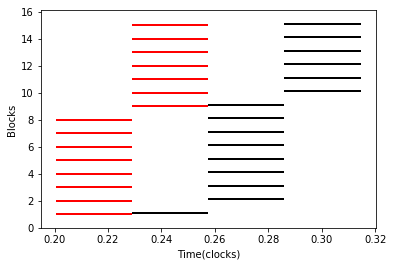

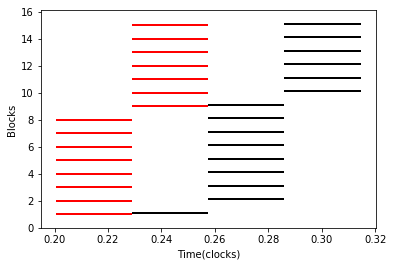

In [26]:
def Plot_sm_trace(df_sm):
    import matplotlib.pyplot as plt
    
    # color to pick
    color_list = ['r', 'k', 'b', 'g', 'c', 'm', 'y', '#cc0000', '#cc6600', 'cc9900',
                  '#cc3300', '#cccc00', '#99cc00', '#66cc00', '#00cccc', '#0033cc', 
                  '#6600cc', '#cc00cc', '#ff99cc', 'ffcc00']
    
    total_color = len(color_list) 
    
    kern_ids = df_sm['kernel_id'].unique()
    
    x0_dd = {}
    x1_dd = {}
    y0_dd = {}
    
    ylim_max = 0
    
    for kid in kern_ids:
        offset = 0.1 * kid
        df_kern = df_sm.loc[df_sm['kernel_id'] == kid] # get the data for current kernel on
        df_kern['y_axis'] = pd.Series(np.arange(1,len(df_kern.index)+1) + offset, 
                                      index=df_kern.index) # adding y_axis label
    
        x0_dd[kid] = df_kern['block_start']
        x1_dd[kid] = df_kern['block_end']
        y0_dd[kid] = df_kern['y_axis']

        current_ymax = max(df_kern['y_axis']) + 1
    
        if ylim_max < current_ymax:
            ylim_max = current_ymax
    

    axes = plt.gca()
    axes.set_ylim([0, ylim_max])

    for kid in kern_ids:
        cid = int(kid) % total_color
        plt.hlines(y0_dd[kid], x0_dd[kid], x1_dd[kid], lw=2, color=color_list[cid])

    
                                
# #     plt.title('Memory Bound')
    plt.xlabel('Time(clocks)')
    plt.ylabel('Blocks')
    plt.show()
    

#---------------------
# plot
#---------------------
df_sm = sm_trace[0]

Plot_sm_trace(df_sm)

df_sm = sm_trace[1]

Plot_sm_trace(df_sm)
